In [1]:
import os, pickle, h5py, re
import pandas as pd
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
os.environ['PATH'] = '/opt/anaconda3/bin:/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'

In [142]:
def get_top_genes_and_barcodes_list(file_name, n_genes=100):
    ''' Takes a 10x .h5 file and a number of genes (n) and returns a list of the top n expressed genes by counts'''
    dset = h5py.File(file_name, 'r')
    dset = dset['matrix']
    indices = dset['indices']
    data = dset['data']
    features = dset['features']
    ids = features['id']
    names = features['name']
    barcodes = pd.Series(dset['barcodes'][()]).astype('str').str.replace('b','').str.replace("'",'')
    
    counts = pd.DataFrame({'count':data,'gene':indices})
    counts = counts.groupby('gene').sum().reset_index()
    
    ensembl = pd.DataFrame({'ids':ids,'names':names})
    ensembl = ensembl.apply(lambda x: x.astype('str').str.replace('b','')).reset_index()
    
    temp = pd.merge(left=counts,right=ensembl,how="left",left_on='gene',right_on='index')
    top_genes = temp.sort_values('count',ascending=False).reset_index()[['count','ids','names']].head(n_genes)
    
    return top_genes, barcodes

In [98]:
def gtf_top_genes(top_genes, gtf_file):
    ''' Takes a list of genes and ensembl gtf file and makes a data frame that has a 
    column for chromosome, strand and a column that contains a set of all the genomic positions inside exons
    This is slow
    '''
    exon_list=[]
    chrom_list=[]
    strand_list=[]
    for i in top_genes['ids']:
        print(i)
        ensembl = !grep $i $gtf_file | cut -f1,3,4,5,7
        try:
            exons = list(map(lambda x: ('\texon') in x, ensembl))
            ensembl = np.array(ensembl)
            ensembl = ensembl[exons]
            chrom = re.findall('(chr[^\t]*)',ensembl[0])[0]
            temp = list(map(lambda x: set(x), map(lambda x: range(int(re.findall('\t([0-9]*)',x)[1]),\
                                                      int(re.findall('\t([0-9]*)',x)[2])), ensembl)))
            exons = list(set([i for i in temp for i in i]))
            exon_list.append(exons)
            chrom_list.append(chrom)
            strand = ensembl[0][-1]
            strand_list.append(strand)
        except: #in case id is not in gtf for some reason
            exon_list.append(0)
            chrom_list.append(0)
            strand_list.append(0)
            
    df  = pd.DataFrame({'gene_id':top_genes['ids'], 'name':top_genes['names'], 'chrom':chrom_list, 'exons':exon_list, 'strand':strand_list})
    df = df[df['chrom'] != 0] 
    return df

In [260]:
def samtools_view(df, filtered_barcodes, bam_file): 
    ''' Takes a df from gtf_top_genes and finds all reads that start between the first exon position and the last. 
    Makes a column for all of the cell barcodes and a column for all the read end positions relative to the first exon position.
    '''
    df = df.reset_index()
    read_stops_list_of_list=[]
    barcodes_list_of_list = []
    for i in range(len(df)):
        if df.loc[i,'strand'] == "+":
            print(i)
            chrom = df.loc[i,'chrom']
            start = min(df.loc[i, 'exons'])
            stop = max(df.loc[i, 'exons'])
            view = !samtools view $bam_file $chrom:$start-$stop

            #print('parsing view')
            umi = list(map(lambda x: re.findall('UB:Z:([A-Z]+)', x),view))
            barcodes = list(map(lambda x: re.findall('CB:Z:([A-Z]+-[0-9]+)', x),view))
            read_strand = list(map(lambda x: x.split('\t')[1],view))
            read_starts = list(map(lambda x: x.split('\t')[3],view))
            cigars = list(map(lambda x: x.split('\t')[5],view))
            cigars = list(map(lambda x: re.findall('[0-9]+', x), cigars))
            cigars = list(map(lambda x: sum([int(s) for s in x]), cigars))
            read_stops = np.array(list(map(int,read_starts))) + np.array(cigars)
            #print('making test')

            test = pd.DataFrame({'umi':umi,'read_starts':read_starts,'read_strand':read_strand,'barcodes':barcodes,'read_stops':read_stops})
            test = test[test['read_strand']=='0']
            test = test[(test['read_stops'] < stop + 300000)]
            test = test[list(map(lambda x: len(x) != 0, test['umi']))]
            test = test[list(map(lambda x: len(x) != 0, test['barcodes']))]
            test['umi'] = list(map(lambda x: x[0], test['umi']))
            test['barcodes'] = list(map(lambda x: x[0], test['barcodes']))
            test = test[test['barcodes'].isin(filtered_barcodes)]
            test = test.sort_values(by=['umi','read_starts']) #should this be stops?
            test = test.drop_duplicates('umi', keep='first')
            #print('appending_list')

            read_stops_list_of_list.append(list(test['read_stops']))
            barcodes_list_of_list.append(list(test['barcodes']))
            
        if df.loc[i,'strand'] == "-":
            print(i)
            chrom = df.loc[i,'chrom']
            actual_start = min(df.loc[i, 'exons']) 
            start = min(df.loc[i, 'exons']) - 300000
            stop = max(df.loc[i, 'exons'])
            view = !samtools view $bam_file $chrom:$start-$stop

            #print('parsing view')
            umi = list(map(lambda x: re.findall('UB:Z:([A-Z]+)', x),view))
            barcodes = list(map(lambda x: re.findall('CB:Z:([A-Z]+-[0-9]+)', x),view))
            read_strand = list(map(lambda x: x.split('\t')[1],view))
            read_starts = list(map(lambda x: x.split('\t')[3],view))
            cigars = list(map(lambda x: x.split('\t')[5],view))
            cigars = list(map(lambda x: re.findall('[0-9]+', x), cigars))
            cigars = list(map(lambda x: sum([int(s) for s in x]), cigars))
            read_stops = np.array(list(map(int,read_starts))) + np.array(cigars)

            #print('making test')
            test = pd.DataFrame({'umi':umi,'read_starts':read_starts,'read_strand':read_strand,'barcodes':barcodes,'read_stops':read_stops})
            test = test[test['read_strand']=='16']
            test = test[(test['read_stops'] > actual_start) & (test['read_stops'] < stop)]
            test = test[list(map(lambda x: len(x) != 0, test['umi']))]
            test = test[list(map(lambda x: len(x) != 0, test['barcodes']))]
            test['umi'] = list(map(lambda x: x[0], test['umi']))
            test['barcodes'] = list(map(lambda x: x[0], test['barcodes']))
            test = test[test['barcodes'].isin(filtered_barcodes)]
            test = test.sort_values(by=['umi','read_starts'], ascending=[True,False])
            test = test.drop_duplicates('umi', keep='first')
            #print('appending_list')

            read_stops_list_of_list.append(list(test['read_starts']))
            barcodes_list_of_list.append(list(test['barcodes']))
        
    df['barcodes'] = barcodes_list_of_list
    df['read_stops'] = read_stops_list_of_list
    return df

In [143]:
os.chdir('/Volumes/Elements/10X bam')

In [488]:
top_genes, filtered_barcodes = get_top_genes_and_barcodes_list('/Volumes/Elements/10X bam/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5',n_genes=1100)

In [490]:
top_genes.head(10)

,count,ids,names
0,3445550,'ENSG00000251562','MALAT1'
1,1441249,'ENSG00000198804','MT-CO1'
2,1081132,'ENSG00000166710','B2M'
3,969345,'ENSG00000198712','MT-CO2'
4,966617,'ENSG00000198938','MT-CO3'
5,916296,'ENSG00000156508','EEF1A1'
6,915619,'ENSG00000198899','MT-ATP6'
7,742086,'ENSG00000205542','TMSB4X'
8,703189,'ENSG00000167526','RPL13'
9,687723,'ENSG00000133112','TPT1'


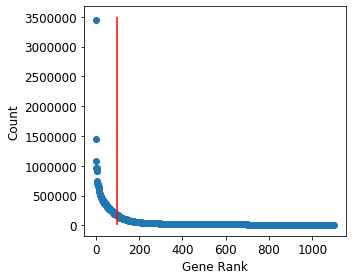

In [495]:
plt.figure(figsize=(5,4))
plt.scatter(x=top_genes.index[:1100],y=top_genes['count'][:1100])
plt.vlines(100,0,3500000,colors="red")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gene Rank', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
plt.tight_layout()
os.chdir('/Users/beth/Desktop')
plt.savefig('Top_Genes.jpg', dpi=600)
#plt.yticks(fontsize=12);

In [172]:
top_genes['names'].str.contains("^\'RP").sum()

84

In [169]:
top_genes.loc[:100,'names'].str.contains("^\'RP").sum()

64

In [174]:
top_genes.loc[:100,'names'].str.contains("^\'MT-").sum()

10

In [175]:
top_genes['names'].str.contains("^\'MT-").sum()

11

In [153]:
top_genes[90:110]

,count,ids,names
90,192520,'ENSG00000171858','RPS21'
91,187855,'ENSG00000197956','S100A6'
92,187808,'ENSG00000221983','UBA52'
93,185363,'ENSG00000204287','HLA-DRA'
94,184822,'ENSG00000197756','RPL37A'
95,179669,'ENSG00000173812','EIF1'
96,176996,'ENSG00000198786','MT-ND5'
97,175273,'ENSG00000163131','CTSS'
98,173998,'ENSG00000142534','RPS11'
99,173826,'ENSG00000116251','RPL22'


In [251]:
top_genes = top_genes[100:]

top genes were MALAT, b2M, mitochondrial, even at pos 100 were translational initiation, ribosomal, I think I will cut off top 100 as housekeepers so this runs faster

In [252]:
os.chdir('/Volumes/BethMac/hg38')

In [253]:
df = gtf_top_genes(top_genes, 'hg38.ensGene.gtf')

'ENSG00000124614'
'ENSG00000204628'
'ENSG00000114391'
'ENSG00000026025'
'ENSG00000184009'
'ENSG00000177606'
'ENSG00000132475'
'ENSG00000241343'
'ENSG00000136942'
'ENSG00000147604'
'ENSG00000163041'
'ENSG00000101439'
'ENSG00000114942'
'ENSG00000089157'
'ENSG00000120129'
'ENSG00000131469'
'ENSG00000171223'
'ENSG00000265972'
'ENSG00000008988'
'ENSG00000142669'
'ENSG00000204525'
'ENSG00000166441'
'ENSG00000070756'
'ENSG00000108518'
'ENSG00000125691'
'ENSG00000174444'
'ENSG00000172809'
'ENSG00000130066'
'ENSG00000051523'
'ENSG00000130522'
'ENSG00000150991'
'ENSG00000085265'
'ENSG00000172757'
'ENSG00000169442'
'ENSG00000254772'
'ENSG00000123349'
'ENSG00000124172'
'ENSG00000111640'
'ENSG00000104904'
'ENSG00000140264'
'ENSG00000204592'
'ENSG00000011600'
'ENSG00000204472'
'ENSG00000163191'
'ENSG00000133639'
'ENSG00000081237'
'ENSG00000092841'
'ENSG00000025708'
'ENSG00000108654'
'ENSG00000103187'
'ENSG00000127528'
'ENSG00000104529'
'ENSG00000231389'
'ENSG00000101608'
'ENSG00000196126'
'ENSG00000

In [259]:
df.head()

,gene_id,name,chrom,exons,strand
100,'ENSG00000124614','RPS10',chr6,"[34417454, 34417455, 34417456, 34417457, 34417...",-
101,'ENSG00000204628','RACK1',chr5,"[181240216, 181240217, 181240218, 181240219, 1...",-
102,'ENSG00000114391','RPL24',chr3,"[101681091, 101681092, 101681093, 101681094, 1...",-
103,'ENSG00000026025','VIM',chr10,"[17235968, 17235969, 17235970, 17235971, 17235...",+
104,'ENSG00000184009','ACTG1',chr17,"[81510400, 81510401, 81510402, 81510403, 81510...",-


In [255]:
len(filtered_barcodes)

10194

In [261]:
df = samtools_view(df, filtered_barcodes, 'Parent_NGSC3_DI_PBMC_possorted_genome_bam.bam')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [262]:
df

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
0,100,'ENSG00000124614','RPS10',chr6,"[34417454, 34417455, 34417456, 34417457, 34417...",-,"[AATCACGAGTAAGAGG-1, AATCACGAGTAAGAGG-1, TTCTT...","[34417470, 34421770, 34418414, 34417484, 34417..."
1,101,'ENSG00000204628','RACK1',chr5,"[181240216, 181240217, 181240218, 181240219, 1...",-,"[CATGAGTAGAGTTGAT-1, GGGTTTAGTCTCGGGT-1, CACAT...","[181237687, 181237705, 181236937, 181236943, 1..."
2,102,'ENSG00000114391','RPL24',chr3,"[101681091, 101681092, 101681093, 101681094, 1...",-,"[TATCTGTCAACCGACC-1, GACCCTTCAGCAGATG-1, ACGTC...","[101681185, 101681186, 101681209, 101681096, 1..."
3,103,'ENSG00000026025','VIM',chr10,"[17235968, 17235969, 17235970, 17235971, 17235...",+,"[CATTGCCGTATCCTCC-1, AGCATCACACGCTTAA-1, TCGGG...","[17237532, 17235855, 17231758, 17229969, 17237..."
4,104,'ENSG00000184009','ACTG1',chr17,"[81510400, 81510401, 81510402, 81510403, 81510...",-,"[TATCCTAGTACGTAGG-1, GTGTGGCTCGACTCCT-1, GTCAC...","[81510068, 81510124, 81510111, 81510012, 81510..."
...,...,...,...,...,...,...,...,...
992,1095,'ENSG00000110324','IL10RA',chr11,"[117998715, 117998716, 117998717, 117998718, 1...",+,"[ATCCGTCTCATACGGT-1, GCGTTTCCACCGTACG-1, TTCAG...","[118001401, 117990654, 118001523, 118001399, 1..."
993,1096,'ENSG00000159128','IFNGR2',chr21,"[33479231, 33432177, 33432178, 33432179, 33432...",+,"[TGGAGAGAGTTGGACG-1, ACCCTCATCCATTGCC-1, CCGAT...","[33437542, 33437426, 33421593, 33421221, 33474..."
994,1097,'ENSG00000182670','TTC3',chr21,"[37093376, 37093377, 37093378, 37093379, 37093...",+,"[CAGCCAGGTTCGTAAC-1, GGGACCTCAATTGCTG-1, TATCC...","[37203129, 37182890, 37077213, 37077320, 37099..."
995,1098,'ENSG00000120616','EPC1',chr10,"[32284422, 32284447, 32286024, 32286075, 32286...",-,"[TGGTACATCGTAACAC-1, TCAAGACGTTATCTTC-1, TTGCA...","[32293606, 32288455, 32353820, 32377937, 32292..."


In [331]:
def seperate_into_peaks(df2):
    final_counts = pd.DataFrame()
    final_summary = pd.DataFrame()
    df = df2.copy()
    df = df.reset_index()
    
    for i in range(len(df)):
        print(i)
        if df.loc[i,'strand'] == "+":
            start = min(df.loc[i,'exons'])
            exons = list(map(lambda x: x - start, df.loc[i,'exons']))
            read_stops = list(map(lambda x: int(x) - start, df.loc[i,'read_stops']))
        if df.loc[i,'strand'] == "-":
            start = max(df.loc[i,'exons'])
            exons = list(map(lambda x: -1*(x - start), df.loc[i,'exons']))
            read_stops = list(map(lambda x: -1*(int(x) - start), df.loc[i,'read_stops']))
       
        read_stops_dict = defaultdict(int)
        barcodes_dict = defaultdict(list)
        read_barcode_zip = zip(df.loc[i,'barcodes'],read_stops)
        for b in read_barcode_zip:
            read_stops_dict[b[1]] += 1
            barcodes_dict[b[1]].append(b[0])
                   
        
        #exons model
    
        read_stops_exons=defaultdict(int)
        barcodes_exons=defaultdict(list)
        for key in exons:
            if read_stops_dict.get(key):
                read_stops_exons[key] = read_stops_dict.get(key)
                barcodes_exons[key] = barcodes_dict.get(key)
                
        for_bgm = [x for y in [[exons.index(i)]*n for i, n in read_stops_exons.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(3,max_iter=2000).fit(for_bgm).predict(for_bgm)
        
        barcodes = [np.array(i).flatten() for i in barcodes_exons.values()]
        barcodes = np.concatenate(barcodes)
                
        exons_results = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
        exons_results['result'] = exons_results['result'].map(lambda x: df.loc[i,'name'] + '_exons_' + str(x))
        exons_results['pos'] = exons_results['pos'].map(lambda x: exons[x])
        
        #other model
        
        try:
            other_read_stops=defaultdict(int)
            other_barcodes=defaultdict(list)
            for key in read_stops_dict.keys():
                if key not in exons:
                    other_read_stops[key] = read_stops_dict.get(key)
                    other_barcodes[key] = barcodes_dict.get(key)

            for_bgm = [x for y in [[i]*n for i, n in other_read_stops.items()] for x in y]
            for_bgm = np.array(for_bgm).reshape([-1,1])
            result = BayesianGaussianMixture(3,max_iter=2000).fit(for_bgm).predict(for_bgm)

            barcodes = [np.array(i).flatten() for i in other_barcodes.values()]
            barcodes = np.concatenate(barcodes)

            other_results =  pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes})
            other_results['result'] = other_results['result'].map(lambda x: df.loc[i,'name'] + '_others_' + str(x))
        
            gene_final = pd.concat([exons_results,other_results],axis=0,ignore_index=False)
            
        except ValueError:
            gene_final = exons_results
        
        gene_summary = gene_final.groupby(['result']).agg({'pos':['mean','std','count']})
        
        gene_counts = gene_final.groupby(['barcode','result']).count().rename(columns={'pos':'count'})
        
        final_summary = pd.concat([final_summary, gene_summary],axis=0,ignore_index=False)
        
        final_counts = pd.concat([final_counts,gene_counts],axis=0,ignore_index=False)
        
                  
    #df.drop(['barcodes','exons','read_stops'],axis=1,inplace=True)
    return final_counts, final_summary

In [2]:
os.chdir('/Volumes/BethMac/')

In [3]:
with open('singlecell_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [191]:
test_genes = df.iloc[[1,5,10,15,20,25,30,35,40,45,475,480,485,490,495,500,505,510,515,520,995,990,985,980,975,970,965,960,955,950]]

In [192]:
test_genes.shape

(30, 8)

In [332]:
counts, summaries = seperate_into_peaks(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


In [308]:
_, summaries_test_2_2 = seperate_into_peaks(test_genes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [309]:
_, summaries_test_2_3 = seperate_into_peaks(test_genes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [208]:
summaries_test_4_1 = summaries_test_4_1.droplevel(level=0,axis=1)

In [216]:
summaries_test_4_1 = summaries_test_4_1.reset_index()

In [218]:
summaries_test_4_1['name'] = summaries_test_4_1['result'].str.extract("\'(.*)\'")[0]

In [224]:
summaries_test_4_1['mean_round'] = summaries_test_4_1['mean'].map(lambda x: round(x, -1))

In [225]:
summaries_test_4_1.head()

,result,mean,std,count,name,mean_round
0,'RACK1'_exons_0,11098.321073,32.787568,87491,RACK1,11100.0
1,'RACK1'_exons_1,10448.920020,28.123253,68567,RACK1,10450.0
2,'RACK1'_exons_2,9383.074595,1483.510228,11730,RACK1,9380.0
3,'RACK1'_exons_3,8997.294691,24.853537,923,RACK1,9000.0
4,'RACK1'_others_0,10003.183685,84.607163,1704,RACK1,10000.0


In [257]:
summaries_test_3_1.shape

(173, 3)

In [258]:
summaries_test_3_2.shape

(175, 3)

In [259]:
summaries_test_3_3.shape

(173, 3)

In [272]:
131/(np.mean([173,175,173]))

0.7543186180422266

In [326]:
summaries_test_2_3.index.str.contains('exon').sum()

60

In [329]:
54/60

0.9

In [317]:
summaries_test_2_1.shape

(119, 3)

In [316]:
summaries_test_2_3.shape

(120, 3)

In [271]:
112/(np.mean([218,217,219]))

0.5137614678899083

In [263]:
summaries_test_5_1.shape

(269, 3)

In [264]:
summaries_test_5_2.shape

(264, 3)

In [265]:
summaries_test_5_3.shape

(262, 3)

In [270]:
167/(np.mean([269,264,262]))

0.630188679245283

In [616]:
summaries_test_4_1['mean_round'] = summaries_test_4_1['mean'].map(lambda x: round(x,-2))

In [465]:
def summaries_process(summaries):
    summaries = summaries.droplevel(level=0, axis=1)
    summaries = summaries.reset_index()
    summaries['name'] = summaries['result'].str.extract("\'(.*)\'")[0]
    summaries['mean_round'] = summaries['mean'].map(lambda x: round(x,-2))
    summaries['mean_round_down'] = summaries['mean'].map(lambda x: round(x,-2) - 100)
    summaries['mean_round_up'] = summaries['mean'].map(lambda x: round(x,-2) + 100)
    return summaries

In [611]:
def merge_summaries(sum1, sum2, sum3):
    #sum1 = summaries_process(sum1)
    sum2 = summaries_process(sum2)
    sum3 = summaries_process(sum3)
    temp = pd.merge(sum1, sum2, how = 'inner', left_on = ['name','mean_round'], right_on = ['name','mean_round'])
    temp2 = pd.merge(sum1, sum2, how = 'inner', left_on = ['name','mean_round'], right_on = ['name','mean_round_down'])
    temp3 = pd.merge(sum1, sum2, how = 'inner', left_on = ['name','mean_round'], right_on = ['name','mean_round_up'])
    temp4= pd.concat([temp,temp2,temp3],axis=0)
    
    temp = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round'], right_on = ['name','mean_round'],suffixes=('_a','_b'))
    temp2 = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round'], right_on = ['name','mean_round_down'],suffixes=('_a','_b'))
    temp3 = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round'], right_on = ['name','mean_round_up'],suffixes=('_a','_b'))
    temp5 = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round_x'], right_on = ['name','mean_round'],suffixes=('_a','_b'))
    temp6 = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round_x'], right_on = ['name','mean_round_down'],suffixes=('_a','_b'))
    temp7 = pd.merge(temp4, sum3, how = "inner", left_on = ['name','mean_round_x'], right_on = ['name','mean_round_up'],suffixes=('_a','_b'))
    temp8 = pd.concat([temp,temp2,temp3,temp7,temp5,temp6],axis=0)
    
    return temp8

In [617]:
test4 = merge_summaries(summaries_test_4_1, summaries_test_4_2,summaries_test_4_3)

In [635]:
test5 = test5.drop_duplicates(['result'])

In [629]:
201/265

0.7584905660377359

In [632]:
test4.shape

(151, 24)

In [453]:
test5.shape

(172, 24)

In [461]:
test3[5:15]

,result_x,mean_x,std_x,count_x,name,mean_round,mean_round_down_x,mean_round_up_x,result_y,mean_y,...,mean_round_x,mean_round_y,result,mean,std,count,mean_round_down,mean_round_up,mean_round_a,mean_round_b
5,'RACK1'_others_2,153239.640000,119374.245863,25,RACK1,153240.0,153230.0,153250.0,'RACK1'_others_1,153239.640000,...,NaN,NaN,'RACK1'_others_1,153239.640000,119374.245863,25,153230.0,153250.0,NaN,NaN
6,'JUN'_others_0,3577.350610,32.033177,328,JUN,3580.0,3570.0,3590.0,'JUN'_others_0,3577.350610,...,NaN,NaN,'JUN'_others_0,3577.350610,32.033177,328,3570.0,3590.0,NaN,NaN
7,'JUN'_others_1,135321.812500,60389.582506,16,JUN,135320.0,135310.0,135330.0,'JUN'_others_1,135321.812500,...,NaN,NaN,'JUN'_others_1,135321.812500,60389.582506,16,135310.0,135330.0,NaN,NaN
8,'H3F3A'_exons_0,9965.626418,481.020786,85609,H3F3A,9970.0,9960.0,9980.0,'H3F3A'_exons_0,9965.626418,...,NaN,NaN,'H3F3A'_exons_1,9965.626418,481.020786,85609,9960.0,9980.0,NaN,NaN
9,'H3F3A'_exons_1,9560.935432,308.629456,41166,H3F3A,9560.0,9550.0,9570.0,'H3F3A'_exons_1,9560.935432,...,NaN,NaN,'H3F3A'_exons_0,9560.935432,308.629456,41166,9550.0,9570.0,NaN,NaN
10,'H3F3A'_exons_2,3791.851241,459.373895,11159,H3F3A,3790.0,3780.0,3800.0,'H3F3A'_exons_2,3791.851241,...,NaN,NaN,'H3F3A'_exons_2,3791.851241,459.373895,11159,3780.0,3800.0,NaN,NaN
11,'RPL27'_exons_0,4549.885802,84.863008,97410,RPL27,4550.0,4540.0,4560.0,'RPL27'_exons_0,4549.885802,...,NaN,NaN,'RPL27'_exons_0,4549.885802,84.863008,97410,4540.0,4560.0,NaN,NaN
12,'RPL27'_exons_1,545.588235,168.402061,272,RPL27,550.0,540.0,560.0,'RPL27'_exons_1,545.588235,...,NaN,NaN,'RPL27'_exons_1,545.588235,168.402061,272,540.0,560.0,NaN,NaN
13,'RPL27'_exons_2,3028.190507,1313.789590,17086,RPL27,3030.0,3020.0,3040.0,'RPL27'_exons_2,3028.190507,...,NaN,NaN,'RPL27'_exons_2,3028.190507,1313.789590,17086,3020.0,3040.0,NaN,NaN
14,'RPL27'_others_0,4172.335223,1037.150071,15700,RPL27,4170.0,4160.0,4180.0,'RPL27'_others_0,4172.335223,...,NaN,NaN,'RPL27'_others_0,4172.335223,1037.150071,15700,4160.0,4180.0,NaN,NaN


In [480]:
summaries_test_3_1[summaries_test_3_1.index.isin(test3['result_x'])==False]

pos                     
                             mean           std  count
result                                                
'JUN'_exons_2         3436.888014     76.403823   7751
'H3F3A'_others_0      7278.120229   3101.056607  11004
'H3F3A'_others_1     44827.093750  19146.110530     32
'H3F3A'_others_2    154253.256410  60243.833389     39
'RPL4'_exons_0       24755.897748    288.203746  10034
'RPL4'_exons_2       22187.899669   1587.042735   5741
'UBC'_others_1       56913.500000  22822.998182      8
'UBC'_others_2      188337.000000  18928.346917      3
'HLA-E'_exons_0       4690.570701     65.522826  26492
'HLA-E'_exons_2        729.081563    249.251631   1459
'HLA-E'_others_1    122931.976744  66950.106695     86
'PTPRC'_others_0     86926.547833  19036.117288  60502
'PTPRC'_others_1     29707.199456   8492.762956  31982
'PTPRC'_others_2      9643.393034   5222.041166  22423
'C11orf58'_exons_0  140825.257271   4598.407115  14269
'C11orf58'_exons_1  134834.337389   1451.195439   1808
'C11orf58'_exons_2  138214.469043    110.423099    533
'TOMM20'_exons_1     15712.508422   3356.179814   5462
'TOMM20'_exons_2     17118.868347    103.932346   8849
'SEC11A'_exons_1     29528.980700  13524.617728    829
'SEC11A'_exons_2     44805.347826    291.672270     92
'ICAM3'_exons_0       5831.707101     66.035574   2704
'ICAM3'_exons_2       5050.660225    821.747736    621
'ICAM3'_others_1     60857.800000  38388.113723      5
'LMAN2'_others_2     18074.315789   2694.610127     76
'BCAP31'_exons_1     22118.884007   3419.717866    569
'BCAP31'_exons_2      4798.615385   4032.705108     65
'BCAP31'_others_1     3644.913386   1594.199008    127
'BCAP31'_others_2    18817.200000   4361.927454     60
'CCT5'_others_0       5277.490544   4254.843924    846
'CCT5'_others_1     155591.944444  63160.947526     18
'CCT5'_others_2      32783.222222   5029.549129      9

In [481]:
summaries_test_3_2[summaries_test_3_2.index.isin(test3['result_y'])==False]

pos                     
                             mean           std  count
result                                                
'JUN'_exons_2         2483.352380    941.408410  19093
'H3F3A'_others_0      7278.120229   3101.056607  11004
'H3F3A'_others_1    141939.456522  62686.672169     46
'H3F3A'_others_2     36845.160000  12949.100026     25
'RPL4'_exons_0       24273.401356    766.623439   8115
'RPL4'_exons_1       20992.799234    782.997461   3133
'UBC'_others_1      146433.800000  58920.002887      5
'UBC'_others_2       48025.000000  18705.498112      6
'HLA-E'_exons_0       3544.612645    348.968746  15895
'HLA-E'_exons_1       4471.908668    868.041830  29201
'HLA-E'_others_1    100683.916667  45383.440487     72
'HLA-E'_others_2    237350.571429  34906.921458     14
'PTPRC'_others_0    103259.949435   7603.807861  31840
'PTPRC'_others_1     22729.542502  13853.424796  56750
'PTPRC'_others_2     70215.492837   6230.799215  26317
'C11orf58'_exons_0  142303.345582    563.623455  12709
'C11orf58'_exons_1  134817.625487   1439.753112   1797
'C11orf58'_exons_2  131218.582700   6147.696447   2104
'TOMM20'_exons_0     17118.868347    103.932346   8849
'TOMM20'_exons_1     15712.508422   3356.179814   5462
'SEC11A'_exons_1     29528.980700  13524.617728    829
'SEC11A'_exons_2     44805.347826    291.672270     92
'ICAM3'_exons_1       5050.660225    821.747736    621
'ICAM3'_exons_2       5831.707101     66.035574   2704
'ICAM3'_others_1     44202.250000  10746.195990      4
'ICAM3'_others_2    127480.000000           NaN      1
'LMAN2'_others_2     18074.315789   2694.610127     76
'BCAP31'_exons_1     22118.884007   3419.717866    569
'BCAP31'_exons_2      4798.615385   4032.705108     65
'BCAP31'_others_1     3020.271028    718.507081    107
'BCAP31'_others_2    21107.833333   3060.562047     42
'CCT5'_others_0       5277.490544   4254.843924    846
'CCT5'_others_1     155591.944444  63160.947526     18
'CCT5'_others_2      32783.222222   5029.549129      9

In [482]:
summaries_test_3_3[summaries_test_3_3.index.isin(test3['result'])==False]

pos                     
                             mean           std  count
result                                                
'JUN'_exons_2         2483.352380    941.408410  19093
'H3F3A'_others_1     93231.158537  73051.303545     82
'H3F3A'_others_2      4275.054888   2258.884150   4828
'RPL4'_exons_1       20992.799234    782.997461   3133
'RPL4'_exons_2       24273.401356    766.623439   8115
'UBC'_others_1      146433.800000  58920.002887      5
'UBC'_others_2       48025.000000  18705.498112      6
'HLA-E'_exons_1       4690.570701     65.522826  26492
'HLA-E'_exons_2        729.081563    249.251631   1459
'HLA-E'_others_1    122931.976744  66950.106695     86
'PTPRC'_others_0    103259.949435   7603.807861  31840
'PTPRC'_others_1     22729.542502  13853.424796  56750
'PTPRC'_others_2     70215.492837   6230.799215  26317
'C11orf58'_exons_0  126927.851331   2390.728851   1352
'C11orf58'_exons_1  135627.389902   1922.217409   2357
'C11orf58'_exons_2  142283.867685    644.602354  12901
'TOMM20'_exons_1     15093.756901    404.350896   3550
'TOMM20'_exons_2     17872.895967   3795.845289   1711
'SEC11A'_exons_0     45460.368421    852.389755    266
'SEC11A'_exons_2     25204.822901  11923.444590    655
'ICAM3'_exons_2       5394.132690    490.182537    829
'ICAM3'_others_1     60857.800000  38388.113723      5
'LMAN2'_others_0     17769.456790   2870.139853     81
'BCAP31'_exons_0     18416.382759   8855.764460    290
'BCAP31'_exons_2     21271.543307    504.906789    254
'BCAP31'_others_0     3644.913386   1594.199008    127
'BCAP31'_others_2    18817.200000   4361.927454     60
'CCT5'_others_0      10038.815385   3263.006247    325
'CCT5'_others_1     118206.269231  77372.522380     26
'CCT5'_others_2       2345.752874    739.139925    522

In [625]:
sum(['exons' in test5['result'].unique()])

0

In [280]:
test4['result'].str.contains('other').sum()

52

In [281]:
test5['result'].str.contains('other').sum()

67

In [647]:
115/128

0.8984375

In [643]:
summaries_test_5_2[summaries_test_5_2['pos']['count']>summaries_test_5_2['pos']['std']].shape

(128, 3)

In [639]:
test5[test5['count']>test5['std']].shape

(115, 24)

In [246]:
test_34 = pd.merge(test3,test4, how="inner", left_on = ['name','mean_round'], right_on = ['name','mean_round'])

In [322]:
test_35 = pd.merge(test3,test5, how="inner", left_on = ['name','mean_round'], right_on = ['name','mean_round'])

In [318]:
test_23 = pd.merge(test2,test3, how="inner", left_on = ['name','mean_round'], right_on = ['name','mean_round'])

In [323]:
test_35.shape

(48, 26)

In [176]:
os.chdir('/Users/beth/Documents/Python/')

In [360]:
with open('1000_gene_counts_4.pickle', 'wb') as write_file:
    pickle.dump(counts_2, write_file)

In [361]:
with open('1000_gene_summaries_4.pickle', 'wb') as write_file:
    pickle.dump(summaries_2, write_file)

In [44]:
with open('1000_gene_summaries_2.pickle', 'rb') as read_file:
    summaries = pickle.load(read_file)

In [37]:
with open('1000_gene_counts_2.pickle', 'rb') as read_file:
    counts = pickle.load(read_file)

In [77]:
summaries_2.head()

pos                     
                         mean          std   count
result                                            
'RPS10'_exons_0   5927.917284  1679.614896  157455
'RPS10'_exons_1   1383.836229   131.707736   29523
'RPS10'_exons_2   8643.987743    79.958618   26924
'RPS10'_exons_3   8603.208354   128.349455   20518
'RPS10'_others_0  6710.121718  1065.203052     419

In [7]:
counts.shape

(14670149, 1)

In [5]:
summaries.shape

(7462, 3)

In [333]:
counts.head()

count
barcode            result                 
AAACCCACATAACTCG-1 'RPS10'_exons_0      37
                   'RPS10'_exons_1       7
                   'RPS10'_exons_2       5
                   'RPS10'_others_0      1
AAACCCACATGTAACC-1 'RPS10'_exons_0      16

In [334]:
summaries.head()

pos                      
                           mean           std   count
result                                               
'RPS10'_exons_0     5928.011299   1679.438864  157451
'RPS10'_exons_1     4846.354271   3628.031610   56454
'RPS10'_exons_2     8604.395662     82.668636   20515
'RPS10'_others_0    4307.372157   2130.855845    1099
'RPS10'_others_1  123509.285714  84165.415783       7

In [335]:
summaries_2 = summaries[summaries['pos']['count']>summaries['pos']['std']]

In [336]:
summaries_2

pos                      
                           mean           std   count
result                                               
'RPS10'_exons_0     5928.011299   1679.438864  157451
'RPS10'_exons_1     4846.354271   3628.031610   56454
'RPS10'_exons_2     8604.395662     82.668636   20515
'RACK1'_exons_0    11098.321073     32.787568   87491
'RACK1'_exons_1    10448.920020     28.123253   68567
...                         ...           ...     ...
'IFNGR2'_exons_0   34489.573475    727.726937    8166
'IFNGR2'_others_1  33717.286461   1040.940592    2105
'TTC3'_others_0     3574.574836   1426.280864    2432
'TAOK3'_others_0   59532.411963  17653.456993   18708
'TAOK3'_others_1   17822.604665   7423.535853   10118

[2721 rows x 3 columns]

In [337]:
test = summaries_2.index.str.extract("\'(.*)\'")

In [338]:
test[0].value_counts()

MT-ND4L    6
PABPC1     6
ANXA1      6
CLEC7A     5
TUBA1A     5
          ..
RSL24D1    1
CANX       1
FOXP1      1
CHD2       1
FLNA       1
Name: 0, Length: 973, dtype: int64

In [339]:
keep = test[0].value_counts() > 1

In [340]:
keep = keep[keep == True].index

In [341]:
summaries_2 = summaries_2.droplevel(level=0,axis=1)

In [342]:
test[0]

0        RPS10
1        RPS10
2        RPS10
3        RACK1
4        RACK1
         ...  
2716    IFNGR2
2717    IFNGR2
2718      TTC3
2719     TAOK3
2720     TAOK3
Name: 0, Length: 2721, dtype: object

In [346]:
summaries_2['name'] = test[0]

In [344]:
summaries_2 = summaries_2.reset_index()

In [347]:
summaries_2.head()

,result,mean,std,count,name
0,'RPS10'_exons_0,5928.011299,1679.438864,157451,RPS10
1,'RPS10'_exons_1,4846.354271,3628.031610,56454,RPS10
2,'RPS10'_exons_2,8604.395662,82.668636,20515,RPS10
3,'RACK1'_exons_0,11098.321073,32.787568,87491,RACK1
4,'RACK1'_exons_1,10448.920020,28.123253,68567,RACK1


In [348]:
summaries_2 = summaries_2[summaries_2['name'].isin(keep)]

In [350]:
summaries_2

,result,mean,std,count,name
0,'RPS10'_exons_0,5928.011299,1679.438864,157451,RPS10
1,'RPS10'_exons_1,4846.354271,3628.031610,56454,RPS10
2,'RPS10'_exons_2,8604.395662,82.668636,20515,RPS10
3,'RACK1'_exons_0,11098.321073,32.787568,87491,RACK1
4,'RACK1'_exons_1,10448.920020,28.123253,68567,RACK1
...,...,...,...,...,...
2715,'IL10RA'_exons_2,931.282880,105.782470,1361,IL10RA
2716,'IFNGR2'_exons_0,34489.573475,727.726937,8166,IFNGR2
2717,'IFNGR2'_others_1,33717.286461,1040.940592,2105,IFNGR2
2719,'TAOK3'_others_0,59532.411963,17653.456993,18708,TAOK3


In [352]:
counts = counts.reset_index()

In [353]:
counts_2 = counts[counts['result'].isin(summaries_2['result'])]

In [355]:
counts_2.shape

(9503741, 3)

In [356]:
counts.shape

(13386489, 3)

In [67]:
summaries[summaries.index.str.contains('ENSG00000277734')]

pos                    
                                    mean          std  count
result                                                      
'ENSG00000277734'_exon_1   270961.843429  1777.771919  23146
'ENSG00000277734'_other_1  184510.912356  1093.699342   3982

In [58]:
counts = counts.reset_index()

In [60]:
counts = counts[counts['result'].isin(summaries.index)]

In [60]:
counts = counts.sort_values('result')

In [64]:
counts['result'].str.contains('ENSG00000000938')

11725887     True
11727312     True
11732060     True
11727309     True
11727308     True
            ...  
20109589    False
20104580    False
20099688    False
20098205    False
20097297    False
Name: result, Length: 20604655, dtype: bool

In [67]:
counts.loc[counts['result'].str.contains('ENSG00000000938'),]

,barcode,result,count
11725887,CGTAATGCACACCGCA-1,'ENSG00000000938'_exon_0,22
11727312,GACCTTCAGGCGCTCT-1,'ENSG00000000938'_exon_0,54
11732060,TGAGACTGTGGCTGAA-1,'ENSG00000000938'_exon_0,7
11727309,GACCTTCAGCCACAAG-1,'ENSG00000000938'_exon_0,13
11727308,GACCTTCAGATTGTGA-1,'ENSG00000000938'_exon_0,2
...,...,...,...
11727015,GAAACCTGTATTTCGG-1,'ENSG00000000938'_other_3,18
11726056,CTAAGTGAGTACAGAT-1,'ENSG00000000938'_other_3,8
11724202,CACTGAATCTTTCCAA-1,'ENSG00000000938'_other_3,1
11720812,AAAGAACAGCGGGTAT-1,'ENSG00000000938'_other_3,5


In [68]:
counts = counts.loc[counts['result'].str.contains('ENSG00000000938'),].pivot(index = 'barcode', columns = "result")

In [69]:
counts.head()

count                           \
result             'ENSG00000000938'_exon_0 'ENSG00000000938'_exon_1   
barcode                                                                
AAACCCACACCGGAAA-1                      NaN                      NaN   
AAACCCACACGCAAAG-1                      3.0                      NaN   
AAACCCACATAACTCG-1                     40.0                      NaN   
AAACCCAGTGAGTCAG-1                     13.0                      NaN   
AAACGAACAGTCAGTT-1                     13.0                      NaN   

                                                                      \
result             'ENSG00000000938'_exon_2 'ENSG00000000938'_exon_3   
barcode                                                                
AAACCCACACCGGAAA-1                      NaN                      NaN   
AAACCCACACGCAAAG-1                      NaN                      NaN   
AAACCCACATAACTCG-1                      NaN                      5.0   
AAACCCAGTGAGTCAG-1                      1.0                      NaN   
AAACGAACAGTCAGTT-1                      NaN                      1.0   

                                                                        \
result             'ENSG00000000938'_other_0 'ENSG00000000938'_other_1   
barcode                                                                  
AAACCCACACCGGAAA-1                       1.0                       NaN   
AAACCCACACGCAAAG-1                       NaN                       NaN   
AAACCCACATAACTCG-1                       NaN                       NaN   
AAACCCAGTGAGTCAG-1                       NaN                       NaN   
AAACGAACAGTCAGTT-1                       NaN                       NaN   

                                                                        
result             'ENSG00000000938'_other_2 'ENSG00000000938'_other_3  
barcode                                                                 
AAACCCACACCGGAAA-1                       NaN                       NaN  
AAACCCACACGCAAAG-1                       NaN                       NaN  
AAACCCACATAACTCG-1                       NaN                       1.0  
AAACCCAGTGAGTCAG-1                       NaN                       NaN  
AAACGAACAGTCAGTT-1                       NaN                       NaN

In [70]:
counts.shape

(6411, 8)

In [71]:
counts.corr()

count  \
result                          'ENSG00000000938'_exon_0   
      result                                               
count 'ENSG00000000938'_exon_0                  1.000000   
      'ENSG00000000938'_exon_1                  0.069449   
      'ENSG00000000938'_exon_2                  0.043933   
      'ENSG00000000938'_exon_3                  0.223720   
      'ENSG00000000938'_other_0                 0.108550   
      'ENSG00000000938'_other_1                 0.012228   
      'ENSG00000000938'_other_2                 0.088675   
      'ENSG00000000938'_other_3                 0.138849   

                                                          \
result                          'ENSG00000000938'_exon_1   
      result                                               
count 'ENSG00000000938'_exon_0                  0.069449   
      'ENSG00000000938'_exon_1                  1.000000   
      'ENSG00000000938'_exon_2                  0.061327   
      'ENSG00000000938'_exon_3                  0.035014   
      'ENSG00000000938'_other_0                 0.016073   
      'ENSG00000000938'_other_1                      NaN   
      'ENSG00000000938'_other_2                 0.731219   
      'ENSG00000000938'_other_3                -0.097626   

                                                          \
result                          'ENSG00000000938'_exon_2   
      result                                               
count 'ENSG00000000938'_exon_0                  0.043933   
      'ENSG00000000938'_exon_1                  0.061327   
      'ENSG00000000938'_exon_2                  1.000000   
      'ENSG00000000938'_exon_3                  0.018572   
      'ENSG00000000938'_other_0                -0.008968   
      'ENSG00000000938'_other_1                      NaN   
      'ENSG00000000938'_other_2                 0.158114   
      'ENSG00000000938'_other_3                -0.004784   

                                                          \
result                          'ENSG00000000938'_exon_3   
      result                                               
count 'ENSG00000000938'_exon_0                  0.223720   
      'ENSG00000000938'_exon_1                  0.035014   
      'ENSG00000000938'_exon_2                  0.018572   
      'ENSG00000000938'_exon_3                  1.000000   
      'ENSG00000000938'_other_0                -0.015146   
      'ENSG00000000938'_other_1                 0.000000   
      'ENSG00000000938'_other_2                 0.051103   
      'ENSG00000000938'_other_3                 0.027934   

                                                           \
result                          'ENSG00000000938'_other_0   
      result                                                
count 'ENSG00000000938'_exon_0                   0.108550   
      'ENSG00000000938'_exon_1                   0.016073   
      'ENSG00000000938'_exon_2                  -0.008968   
      'ENSG00000000938'_exon_3                  -0.015146   
      'ENSG00000000938'_other_0                  1.000000   
      'ENSG00000000938'_other_1                  1.000000   
      'ENSG00000000938'_other_2                  0.362401   
      'ENSG00000000938'_other_3                  0.095246   

                                                           \
result                          'ENSG00000000938'_other_1   
      result                                                
count 'ENSG00000000938'_exon_0                   0.012228   
      'ENSG00000000938'_exon_1                        NaN   
      'ENSG00000000938'_exon_2                        NaN   
      'ENSG00000000938'_exon_3                   0.000000   
      'ENSG00000000938'_other_0                  1.000000   
      'ENSG00000000938'_other_1                  1.000000   
      'ENSG00000000938'_other_2                       NaN   
      'ENSG00000000938'_other_3                 -0.401269   

                                                           \
re

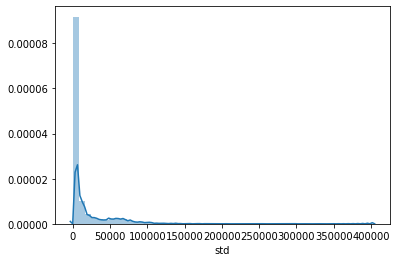

In [307]:
sns.distplot(summaries.droplevel(0,axis=1)['std'])

In [8]:
test = summaries.droplevel(0,axis=1)

In [309]:
test.head()

,mean,std,count
result,,,
'ENSG00000124614'_exon_0,8603.208354,128.349455,20518
'ENSG00000124614'_exon_1,5927.917284,1679.614896,157455
'ENSG00000124614'_exon_2,1383.836229,131.707736,29523
'ENSG00000124614'_exon_3,8643.987743,79.958618,26924
'ENSG00000124614'_other_0,2745.155556,314.264557,675


In [313]:
test['mean'].max()

1055241.0

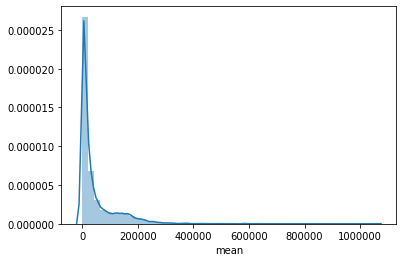

In [311]:
sns.distplot(test['mean'])

In [10]:
import seaborn as sns

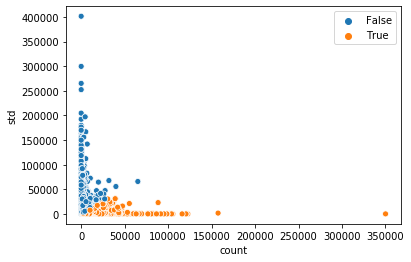

In [17]:
sns.scatterplot(test['count'],test['std'], hue=test['count']>test['std'])

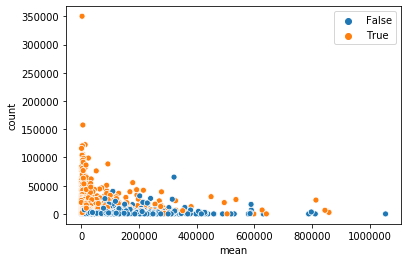

In [18]:
sns.scatterplot(test['mean'],test['count'], hue=test['count']>test['std'])

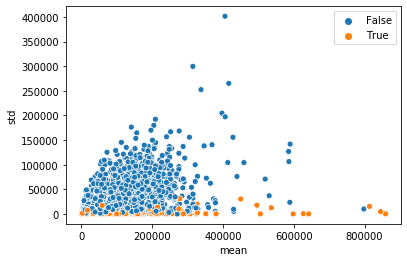

In [20]:
sns.scatterplot(test['mean'],test['std'], hue=test['count']>test['std'])

In [61]:
os.chdir('/Users/beth/Desktop')

In [136]:
! touch test_new.h5

In [62]:
def new_h5(counts,summaries,dset_file,new_dset_file):
    'takes counts and summaries output of seperate_into_peaks function'
    #load the dset_file
    dset = h5py.File(dset_file, 'r')
    dset = dset['matrix']
    indices = dset['indices']
    data = dset['data']
    features = dset['features']
    ids = features['id']
    
    #create the dset2 file and matrix group with barcodes and features group
    ! touch $new_dset_file
    dset2 = h5py.File(new_dset_file, 'w')
    dset2.create_group('matrix')
    dset2['matrix'].create_dataset('barcodes', data = np.array(dset['barcodes']))
    dset2['matrix'].create_group('features')
    
    #add the new features to the old features ids
    summaries = summaries.reset_index()
    summaries['result'] = summaries['result'].str.replace("'","")
    old_genes = np.array(dset['features']['id'],dtype="|S30")
    new_genes = np.array(summaries['result'],dtype='|S30')
    dset2['matrix']['features'].create_dataset('id', data = np.append(old_genes,new_genes), dtype='|S30')
    
    #add the new features to the old features names
    old_genes_names = np.array(dset['features']['name'])
    dset2['matrix']['features'].create_dataset('name', data = np.append(old_genes_names, new_genes), dtype="|S30")
    
    #add extended genome array
    genome = dset['features']['genome'][0]
    genome = np.repeat(genome,dset2['matrix']['features']['id'].shape[0])
    dset2['matrix']['features'].create_dataset('genome', data = genome, dtype = "|S6")
    
    #add extended feature type array 
    feature_type = dset['features']['feature_type'][0]
    feature_type = np.repeat(feature_type,dset2['matrix']['features']['id'].shape[0])
    dset2['matrix']['features'].create_dataset('feature_type', data=feature_type, dtype = "|S15")
    
    #add tag
    tag = dset['features']['_all_tag_keys'][0]
    tag = np.array(tag,dtype='|S6')
    dset2['matrix']['features'].create_dataset('_all_tag_keys', data = tag, dtype = "|S6")
    
    #get a list of all features
    gene_list = list(pd.Series(dset2['matrix']['features']['id']).astype('str').str.replace('b','').str.replace("'",''))
    
    #get a list of all barcodes
    barcodes = list(pd.Series(dset['barcodes']).astype('str').str.replace('b','').str.replace("'",''))
    
    #update the indptr, data and indices arrays from the original dset by inserting new data
    indptr = np.array(dset['indptr'])
    data = np.array(dset['data'])
    indices = np.array(dset['indices'])
    counts = counts.reset_index()
    counts['result'] = counts['result'].str.replace("'",'')
    
    for i,b in enumerate(sorted(list(counts['barcode'].unique()))):
        if i % 1000 == 0:
            print(i)
        if b in barcodes:
            cell_counts = counts[counts['barcode']==b]
            cell_counts['gene_indice']=cell_counts['result'].map(lambda x: gene_list.index(x))
            cell_counts = cell_counts.sort_values(by='gene_indice')
            i = barcodes.index(b)
            pos = indptr[i]
            data = np.insert(data,pos,cell_counts['count'])              
            indices = np.insert(indices,pos,cell_counts['gene_indice'])
            indptr = np.append(indptr[:i+1],indptr[i+1:]+len(cell_counts))
        else: 
            continue
    
    #put the updated arrays in the new dset
    dset2['matrix'].create_dataset('indptr', data = indptr)
    dset2['matrix'].create_dataset('data', data = data)
    dset2['matrix'].create_dataset('indices', data = indices)
    
    #put the new matrix shape in the new dset
    new_shape =np.array([len(dset2['matrix']['features']['id']), len(dset2['matrix']['barcodes'])], dtype='int32')
    dset2['matrix'].create_dataset('shape', data = new_shape, dtype='int32')
    
    

In [357]:
os.chdir('/Users/beth/Desktop')

In [463]:
del counts, summaries

In [464]:
new_h5(counts_2,summaries_2,'Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5','3_peaks_filtered.h5')

0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [140]:
dset2['matrix'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>

In [519]:
test = summaries_2['result'].str.extract("\'(.*)\'")[0].value_counts()

In [521]:
test = test.value_counts()

In [522]:
test[1] = 144

In [524]:
test

3    318
2    274
4    221
5     40
6      3
1    144
Name: 0, dtype: int64

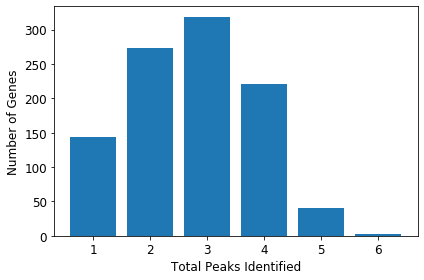

In [526]:
plt.bar(x=test.index,height=test)
plt.xlabel('Total Peaks Identified',fontsize=12)
plt.ylabel('Number of Genes',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
plt.tight_layout()
plt.savefig('total_peaks.jpg')

In [579]:
def peak_correlations(base_gene_id, counts):
    counts = counts.loc[counts['result'].str.contains("'"+base_gene_id+"'"),].pivot(index = 'barcode', columns = "result")
    return counts.corr()

In [582]:
def list_correlations(counts, summaries):
    min_correlations = []
    for g in summaries['result'].str.extract("(\'.*\')")[0].unique():
        c = counts.loc[counts['result'].str.contains(g),].pivot(index = 'barcode', columns = "result")
        c = c.corr().min()
        min_correlations.append(c)
    return min_correlations

In [583]:
min_correlations = list_correlations(counts_2, summaries_2)

In [602]:
with open('min_correlations.pickle', 'wb') as write_file:
    pickle.dump(min_correlations, write_file)

In [584]:
len(min_correlations)

856

In [589]:
min_corr = list(map(min, min_correlations))

In [591]:
np.argsort(min_corr)[0:10]

array([179, 257, 702, 684, 582, 827, 291, 246, 832, 646])

In [601]:
min_correlations[646]

       result          
count  'PRDX5'_exons_0     0.069776
       'PRDX5'_exons_1     0.069776
       'PRDX5'_exons_2    -0.122700
       'PRDX5'_others_0   -0.122700
dtype: float64

In [587]:
min_correlations[1]

       result          
count  'RACK1'_exons_0     0.108908
       'RACK1'_exons_1     0.098615
       'RACK1'_exons_2     0.069880
       'RACK1'_others_0    0.069880
dtype: float64

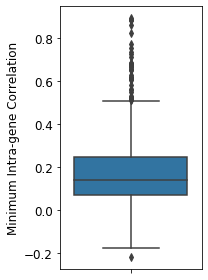

In [590]:
plt.figure(figsize=(3,4))
sns.boxplot(min_corr, orient='v')
plt.ylabel('Minimum Intra-gene Correlation',fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('min_corr.jpg')

In [578]:
counts_2.head()

,barcode,result,count
0,AAACCCACATAACTCG-1,'RPS10'_exons_0,37
1,AAACCCACATAACTCG-1,'RPS10'_exons_1,7
2,AAACCCACATAACTCG-1,'RPS10'_exons_2,5
4,AAACCCACATGTAACC-1,'RPS10'_exons_0,16
5,AAACCCACATGTAACC-1,'RPS10'_exons_1,3


In [580]:
peak_correlations('IGHA1', counts_2)


count                                
result                'IGHA1'_exons_0 'IGHA1'_exons_1 'IGHA1'_exons_2
      result                                                         
count 'IGHA1'_exons_0        1.000000        0.883518        0.986129
      'IGHA1'_exons_1        0.883518        1.000000        0.886361
      'IGHA1'_exons_2        0.986129        0.886361        1.000000

In [239]:
peak_correlations('IGHA1', counts)

count  \
result                          'ENSG00000204257'_exon_0   
      result                                               
count 'ENSG00000204257'_exon_0                  1.000000   
      'ENSG00000204257'_exon_1                       NaN   
      'ENSG00000204257'_exon_2                  0.414537   
      'ENSG00000204257'_exon_3                  0.170148   
      'ENSG00000204257'_other_0                 0.155229   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                 0.165643   

                                                          \
result                          'ENSG00000204257'_exon_1   
      result                                               
count 'ENSG00000204257'_exon_0                       NaN   
      'ENSG00000204257'_exon_1                  1.000000   
      'ENSG00000204257'_exon_2                  0.007778   
      'ENSG00000204257'_exon_3                       NaN   
      'ENSG00000204257'_other_0                      NaN   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                      NaN   

                                                          \
result                          'ENSG00000204257'_exon_2   
      result                                               
count 'ENSG00000204257'_exon_0                  0.414537   
      'ENSG00000204257'_exon_1                  0.007778   
      'ENSG00000204257'_exon_2                  1.000000   
      'ENSG00000204257'_exon_3                  0.212875   
      'ENSG00000204257'_other_0                 0.227897   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                 0.137252   

                                                          \
result                          'ENSG00000204257'_exon_3   
      result                                               
count 'ENSG00000204257'_exon_0                  0.170148   
      'ENSG00000204257'_exon_1                       NaN   
      'ENSG00000204257'_exon_2                  0.212875   
      'ENSG00000204257'_exon_3                  1.000000   
      'ENSG00000204257'_other_0                 0.037449   
      'ENSG00000204257'_other_1                      NaN   
      'ENSG00000204257'_other_2                -0.218218   

                                                           \
result                          'ENSG00000204257'_other_0   
      result                                                
count 'ENSG00000204257'_exon_0                   0.155229   
      'ENSG00000204257'_exon_1                        NaN   
      'ENSG00000204257'_exon_2                   0.227897   
      'ENSG00000204257'_exon_3                   0.037449   
      'ENSG00000204257'_other_0                  1.000000   
      'ENSG00000204257'_other_1                       NaN   
      'ENSG00000204257'_other_2                 -0.161359   

                                                           \
result                          'ENSG00000204257'_other_1   
      result                                                
count 'ENSG00000204257'_exon_0                        NaN   
      'ENSG00000204257'_exon_1                        NaN   
      'ENSG00000204257'_exon_2                        NaN   
      'ENSG00000204257'_exon_3                        NaN   
      'ENSG00000204257'_other_0                       NaN   
      'ENSG00000204257'_other_1                       NaN   
      'ENSG00000204257'_other_2                       NaN   

                                                           
result                          'ENSG00000204257'_other_2  
      result                                               
count 'ENSG00000204257'_exon_0                   0.165643  
      'ENSG00000204257'_exon_1                        NaN  
      'ENSG00000204257'_exon_2                   0.137252  
      'ENSG00000204257'_exon_3                  -0.218218  
     

In [200]:
df.iloc[9,]

index                                                         9
gene_id                                       'ENSG00000147604'
chrom                                                      chr8
exons         [3557, 3558, 3559, 3560, 3561, 3562, 3563, 356...
barcodes      [CATTTCATCCTACCAC-1, ACGGTCGTCTCTAAGG-1, TCCGA...
read_stops    [54262, 143183, 30356, 861, 986, 8717, 87907, ...
Name: 9, dtype: object

In [201]:
test = df[df['gene_id']=="'ENSG00000124614'"]

In [202]:
test.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,0,'ENSG00000124614',chr6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GGGAGTACAGAGTGTG-1, TGTGATGCAGTTTCAG-1, GTAAT...","[7292, 334840, 53004, 165139, 357994, 211003, ..."


In [209]:
df.head()

,index,gene_id,chrom,exons,barcodes,read_stops
0,0,'ENSG00000124614',chr6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[GGGAGTACAGAGTGTG-1, TGTGATGCAGTTTCAG-1, GTAAT...","[7292, 334840, 53004, 165139, 357994, 211003, ..."
1,1,'ENSG00000204628',chr5,"[3307, 3308, 3309, 3310, 3311, 3312, 3313, 331...","[ATTCCCGTCCAAACCA-1, AGAAGCGCAACGGGTA-1, TCACG...","[68499, 776, 109, 1261, 111, 785, 785, 785, 89..."
2,2,'ENSG00000114391',chr3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[CAATCGAGTTGCGGCT-1, ATTCACTTCAGGCGAA-1, TACGG...","[77, 178240, 250634, 180083, 134565, 24195, 21..."
3,3,'ENSG00000026025',chr10,"[7709, 7710, 7711, 7712, 7713, 7714, 7715, 771...","[GTAGGTTAGGGATCAC-1, CATGGATTCTCCCATG-1, CTGCC...","[63689, 6151, 5780, 220549, 6060, 299866, 6028..."
4,4,'ENSG00000184009',chr17,"[429, 430, 431, 432, 433, 434, 435, 436, 437, ...","[GTGTTAGCATATCGGT-1, TATATCCGTTGTACGT-1, ACAAC...","[127861, 56287, 75, 75, 75, 75, 75, 71, 205, 1..."


In [48]:
def graph_exons(gene_name,df):
        #df=df2.copy()
        df=df[df['name']=="'"+gene_name+"'"]
        df=df.reset_index()
        
        if df.loc[0,'strand'] == "+":
            start = min(df.loc[0,'exons'])
            exons = list(map(lambda x: x - start, df.loc[0,'exons']))
            read_stops = list(map(lambda x: int(x) - start, df.loc[0,'read_stops']))
        if df.loc[0,'strand'] == "-":
            start = max(df.loc[0,'exons'])
            exons = list(map(lambda x: -1*(x - start), df.loc[0,'exons']))
            read_stops = list(map(lambda x: -1*(int(x) - start), df.loc[0,'read_stops']))
        
        read_stops_dict = defaultdict(int)
        
        for stop in read_stops:
            read_stops_dict[stop] += 1
            
        read_stops_exons=defaultdict(int)
        for key in exons:
            if read_stops_dict.get(key):
                read_stops_exons[key] = read_stops_dict.get(key)
                
        for_bgm = [x for y in [[exons.index(i)]*n for i, n in read_stops_exons.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(3,max_iter=2000).fit(for_bgm).predict(for_bgm)
        
        exons_results = pd.DataFrame({'result':result,'pos':for_bgm.flatten()})
        exons_results['pos'] = exons_results['pos'].map(lambda x: exons[x])
        
        group_0 = exons_results[exons_results['result'] == 0]
        group_1 = exons_results[exons_results['result'] == 1]
        group_2 = exons_results[exons_results['result'] == 2]
        group_3 = exons_results[exons_results['result'] == 3]
        
        #plt.hist([group_0['pos'],group_1['pos'],group_2['pos'],group_3['pos']],bins=10)
        fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
        ax[0].hist(group_0['pos'],bins=50)
        ax[1].hist(group_1['pos'],bins=50)
        ax[2].hist(group_2['pos'],bins=50)
        #sns.distplot(group_1['pos'],norm_hist=False,kde=False,bins=100)
        #sns.distplot(group_2['pos'],norm_hist=False,kde=False,bins=100)
        #sns.distplot(group_3['pos'],norm_hist=False,kde=False,bins=100)
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)

        plt.xlabel("Distance from first exon start", fontsize=12)
        plt.ylabel("Count",fontsize=12)
        
        return exons_results

In [6]:
import matplotlib.pyplot as plt

In [9]:
df.head()

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
0,100,'ENSG00000124614','RPS10',chr6,"[34417454, 34417455, 34417456, 34417457, 34417...",-,"[AATCACGAGTAAGAGG-1, AATCACGAGTAAGAGG-1, TTCTT...","[34417470, 34421770, 34418414, 34417484, 34417..."
1,101,'ENSG00000204628','RACK1',chr5,"[181240216, 181240217, 181240218, 181240219, 1...",-,"[CATGAGTAGAGTTGAT-1, GGGTTTAGTCTCGGGT-1, CACAT...","[181237687, 181237705, 181236937, 181236943, 1..."
2,102,'ENSG00000114391','RPL24',chr3,"[101681091, 101681092, 101681093, 101681094, 1...",-,"[TATCTGTCAACCGACC-1, GACCCTTCAGCAGATG-1, ACGTC...","[101681185, 101681186, 101681209, 101681096, 1..."
3,103,'ENSG00000026025','VIM',chr10,"[17235968, 17235969, 17235970, 17235971, 17235...",+,"[CATTGCCGTATCCTCC-1, AGCATCACACGCTTAA-1, TCGGG...","[17237532, 17235855, 17231758, 17229969, 17237..."
4,104,'ENSG00000184009','ACTG1',chr17,"[81510400, 81510401, 81510402, 81510403, 81510...",-,"[TATCCTAGTACGTAGG-1, GTGTGGCTCGACTCCT-1, GTCAC...","[81510068, 81510124, 81510111, 81510012, 81510..."


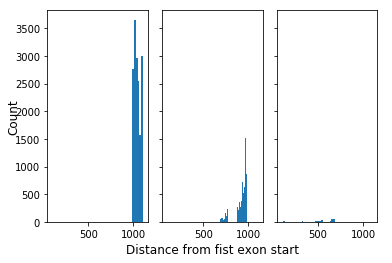

In [5]:
test = graph_exons('NKG7',df)
plt.tight_layout()
os.chdir('/Users/beth/Desktop')
plt.savefig('NKG7.jpg', dpi=600)

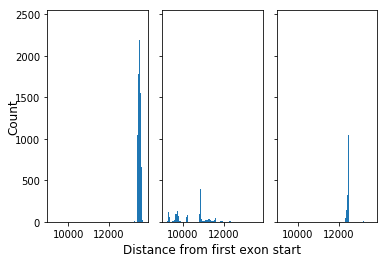

In [49]:
test = graph_exons('GNLY',df)

plt.tight_layout()
os.chdir('/Users/beth/Desktop')
plt.savefig('GNLY.jpg', dpi=600)

In [65]:
test[test['result']==1].count()

result    1469
pos       1469
dtype: int64

In [66]:
test[test['result']==1]['pos'].std()

754.7166546092951

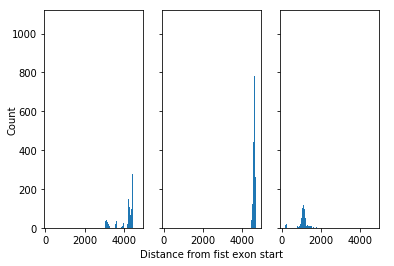

In [45]:
test = graph_exons('C1orf162',df)

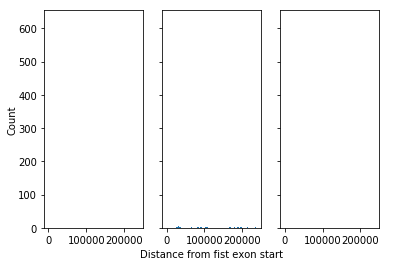

In [76]:
graph_other('C1orf162',df)

In [50]:
test[test['result']==2].count()

result    1161
pos       1161
dtype: int64

In [555]:
test[test['result']==1].mean()

result        1.00000
pos       29755.80438
dtype: float64

In [556]:
test[test['result']==2].mean()

result        2.000000
pos       15845.401208
dtype: float64

In [557]:
test[test['result']==3].mean()

result        3.000000
pos       21389.969507
dtype: float64

In [558]:
test[test['result']==0].mean()

result        0.000000
pos       43017.790087
dtype: float64

In [544]:
summaries[summaries.index.str.contains('ENSG00000115524')]

pos                    
                                    mean           std count
result                                                      
'ENSG00000115524'_exon_0    29693.662738    419.876906  5346
'ENSG00000115524'_exon_1    43029.161214     71.345634  5105
'ENSG00000115524'_exon_2    20122.605451   9769.276300  4770
'ENSG00000115524'_exon_3    32377.109964   6495.903852  1937
'ENSG00000115524'_other_0   19297.767361   6676.228801  1728
'ENSG00000115524'_other_1  186417.870968  69517.313165    31
'ENSG00000115524'_other_2   39882.117096   1890.338503   427
'ENSG00000115524'_other_3    3056.659480   1512.399901  1345

In [564]:
os.chdir('/Volumes/BethMac')

In [566]:
with open('singlecell_df.pickle', 'wb') as write_file:
    pickle.dump(df, write_file)

In [50]:
def graph_other(gene_name,df):
        #df=df2.copy()
        df=df[df['name']=="'"+gene_name+"'"]
        df=df.reset_index()
        
        if df.loc[0,'strand'] == "+":
            start = min(df.loc[0,'exons'])
            exons = list(map(lambda x: x - start, df.loc[0,'exons']))
            read_stops = list(map(lambda x: int(x) - start, df.loc[0,'read_stops']))
        if df.loc[0,'strand'] == "-":
            start = max(df.loc[0,'exons'])
            exons = list(map(lambda x: -1*(x - start), df.loc[0,'exons']))
            read_stops = list(map(lambda x: -1*(int(x) - start), df.loc[0,'read_stops']))
        
        read_stops_dict = defaultdict(int)
        
        for stop in read_stops:
            read_stops_dict[stop] += 1
            
        other_read_stops=defaultdict(int)
            
        for key in read_stops_dict.keys():
            if key not in exons:
                other_read_stops[key] = read_stops_dict.get(key)


        for_bgm = [x for y in [[i]*n for i, n in other_read_stops.items()] for x in y]
        for_bgm = np.array(for_bgm).reshape([-1,1])
        result = BayesianGaussianMixture(3,max_iter=2000).fit(for_bgm).predict(for_bgm)

        other_results =  pd.DataFrame({'result':result,'pos':for_bgm.flatten()})
        
        group_0 = other_results[other_results['result'] == 0]
        group_1 = other_results[other_results['result'] == 1]
        group_2 = other_results[other_results['result'] == 2]
        group_3 = other_results[other_results['result'] == 3]
        
        fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
        ax[0].hist(group_0['pos'],bins=50)
        ax[1].hist(group_1['pos'],bins=50)
        ax[2].hist(group_2['pos'],bins=50)
        #sns.distplot(group_1['pos'],norm_hist=False,kde=False,bins=100)
        #sns.distplot(group_2['pos'],norm_hist=False,kde=False,bins=100)
        #sns.distplot(group_3['pos'],norm_hist=False,kde=False,bins=100)
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)

        plt.xlabel("Distance from first exon start")
        plt.ylabel("Count")

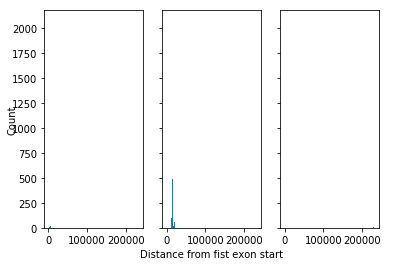

In [59]:
graph_other('IL7R',df)

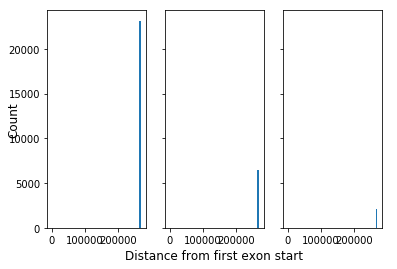

In [53]:
test=graph_exons('TRAC',df)

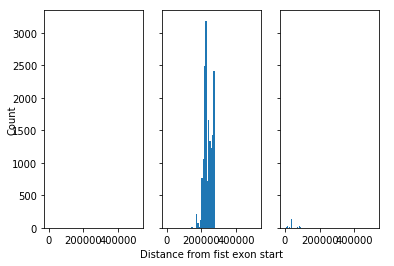

In [61]:
graph_other('TRAC',df)

In [57]:
test=df[df['name']=="'TRAC'"]

In [67]:
min(test.loc[182,'exons'])

22281105

In [68]:
max(test.loc[182,'exons'])

22552154

In [69]:
22552154 - 22281105

271049

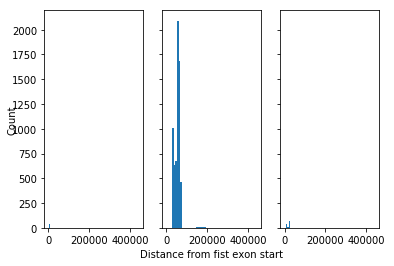

In [72]:
graph_other('STAT3',df)

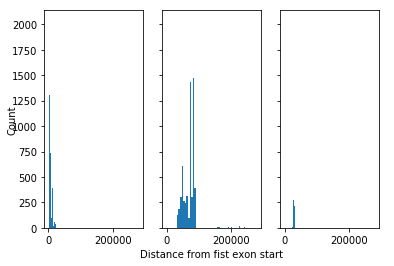

In [9]:
graph_other('RAB7A',df)

In [37]:
df[500:520]

,index,gene_id,name,chrom,exons,strand,barcodes,read_stops
500,601,'ENSG00000173726','TOMM20',chr1,"[235110400, 235110401, 235110402, 235110403, 2...",-,"[ATCTTCATCCCAACTC-1, CCTCTCCGTAACTTCG-1, CGGTC...","[235125848, 235111930, 235112049, 235111833, 2..."
501,602,'ENSG00000164733','CTSB',chr8,"[11862345, 11862346, 11862347, 11862348, 11862...",-,"[ACTTAGGGTCCATAGT-1, ACTTAGGGTCCATAGT-1, ACCGT...","[11866483, 11866597, 11844361, 11843128, 11844..."
502,603,'ENSG00000177700','POLR2L',chr11,"[839721, 839722, 839723, 839724, 839725, 83972...",-,"[CGAGGCTCAAGTGCAG-1, AGATGCTAGCGACCCT-1, TACGC...","[840268, 840211, 842428, 839902, 840376, 84157..."
503,604,'ENSG00000023902','PLEKHO1',chr1,"[150149183, 150149184, 150149185, 150149186, 1...",+,"[GTTGTGAGTGTCTTGA-1, CTTGAGACACTGGATT-1, CCACA...","[150159562, 150159615, 150150996, 150150929, 1..."
504,605,'ENSG00000100941','PNN',chr14,"[39182336, 39182337, 39182338, 39182339, 39182...",+,"[TCACGGGGTCCATAGT-1, TCATTACGTGTCCGGT-1, TCGCA...","[39182128, 39182113, 39182157, 39180833, 39181..."
505,606,'ENSG00000139278','GLIPR1',chr12,"[75498694, 75498695, 75498696, 75498697, 75498...",+,"[TGGTAGTAGACGAGCT-1, AATTCCTCAGGTGAGT-1, TCACA...","[75499582, 75498996, 75499035, 75498852, 75495..."
506,607,'ENSG00000149357','LAMTOR1',chr11,"[72097792, 72097793, 72097794, 72086344, 72097...",-,"[AAGTTCGAGCCGTTAT-1, CAGCACGAGACTTCGT-1, TTCTT...","[72097355, 72097366, 72097452, 72087414, 72097..."
507,608,'ENSG00000123146','ADGRE5',chr19,"[14388450, 14388451, 14388452, 14388453, 14388...",+,"[ACGGTCGGTCCTCCAT-1, ACGGTCGGTCCTCCAT-1, TTTCG...","[14387851, 14387851, 14402722, 14408669, 14387..."
508,609,'ENSG00000115310','RTN4',chr2,"[55050240, 55050241, 55050242, 55050243, 55050...",-,"[CTCATTAGTAGTACGG-1, GTCTAGACAACCCTCT-1, GTCAA...","[55010709, 55050263, 55026610, 55013768, 54972..."
509,610,'ENSG00000173436','MICOS10',chr1,"[19628032, 19628033, 19628034, 19628035, 19628...",+,"[AGCGTATCAACACTAC-1, CATACCCTCCCATACC-1, ATTGG...","[19626524, 19626540, 19626499, 19608966, 19608..."


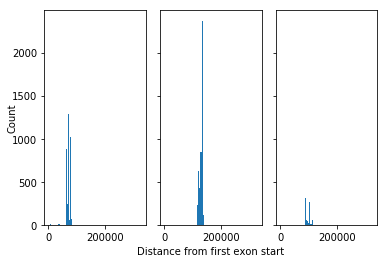

In [51]:
graph_other('RTN4', df)

plt.tight_layout()
os.chdir('/Users/beth/Desktop')
plt.savefig('RTN4.jpg', dpi=600)

,result,pos
0,1,141445
1,1,141704
2,1,141748
3,1,141770
4,1,268568
...,...,...
31652,0,271049
31653,0,271049
31654,0,271049
31655,0,271049


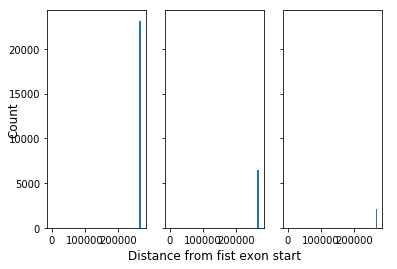

In [75]:
graph_others('TRAC',df)

In [237]:
max(df2.loc[0,'exons']) - min(df2.loc[0,'exons'])

20480

In [227]:
import seaborn as sns

In [213]:
import matplotlib.pyplot as plt

In [76]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_exons.items()] for x in y]

In [77]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [78]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [177]:
test_2 = test[test['result'] == 2]

In [178]:
test_1 = test[test['result'] == 1]

In [179]:
test_0 = test[test['result'] == 0]

In [180]:
test_3 = test[test['result'] == 3]

In [96]:
import matplotlib.pyplot as plt

In [97]:
import seaborn as sns

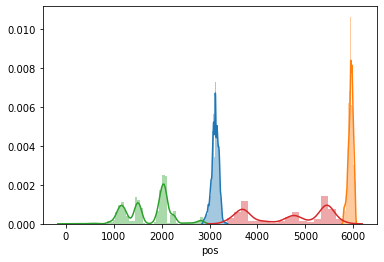

In [181]:
sns.distplot(test_0['pos'])
sns.distplot(test_1['pos'])
sns.distplot(test_2['pos'])
sns.distplot(test_3['pos'])

In [100]:
#fast!
for_bgm = [x for y in [[i]*n for i, n in read_stops_introns.items()] for x in y]

In [101]:
for_bgm = np.array(for_bgm).reshape([-1,1])

In [102]:
for_bgm.shape

(0, 1)

In [98]:
result = BayesianGaussianMixture(4,max_iter=300).fit(for_bgm).predict(for_bgm)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required.

In [79]:
for_bgm.flatten().shape

(3107752,)

In [84]:
test = pd.DataFrame({'result':result,'pos':for_bgm.flatten(),'barcode':barcodes_test})

In [85]:
min = test[test['result']==0]['pos'].min()

In [86]:
max = test[test['result']==0]['pos'].max()

In [87]:
pd.Series(result).value_counts()

0    2166283
1     727600
3     110472
2     103397
dtype: int64

In [81]:
barcodes_test = [np.array(i).flatten() for i in barcodes_exons.values()]

In [82]:
barcodes_test = np.concatenate(barcodes_test)

In [83]:
barcodes_test.shape

(3107752,)

In [ ]:
temp = temp.groupby(['barcode','call']).count().reset_index()

In [187]:
test_2 = test2[test2['result'] == 2]

In [188]:
test_1 = test2[test2['result'] == 1]

In [189]:
test_0 = test2[test2['result'] == 0]

In [190]:
test_3 = test2[test2['result'] == 3]

In [92]:
import matplotlib.pyplot as plt

In [93]:
import seaborn as sns

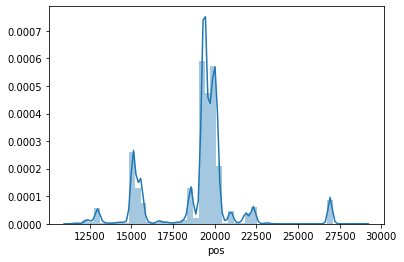

In [192]:
sns.distplot(test_0['pos'])


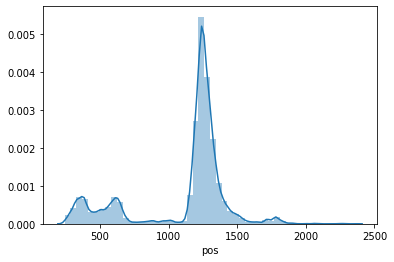

In [193]:
sns.distplot(test_1['pos'])

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

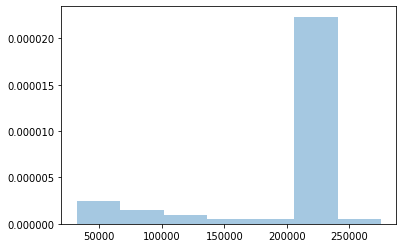

In [194]:
sns.distplot(test_2['pos'])

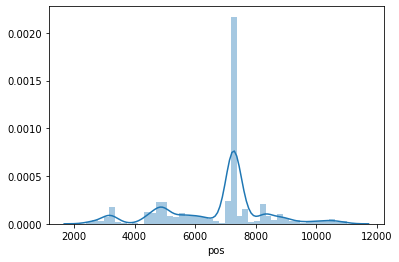

In [195]:
sns.distplot(test_3['pos'])